# Testing Notebook

### Imports and Data Input

In [61]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import interpolate
import time
import data_files

"""Import Data"""
data = data_files.runs_dict

# data_files.file_summary

### Data Cleaning and Organization

File                            L230307.CSV
Run                                  Run 26
Time (min)                            51.15
Max Speed (kts)                   22.181748
Avg Speed (kts)                   12.156009
Battery Expended (%)                     41
Distance Traveled (nm)             5.334693
Average Consumption (kWh/nm)       4.841891
Name: 25, dtype: object


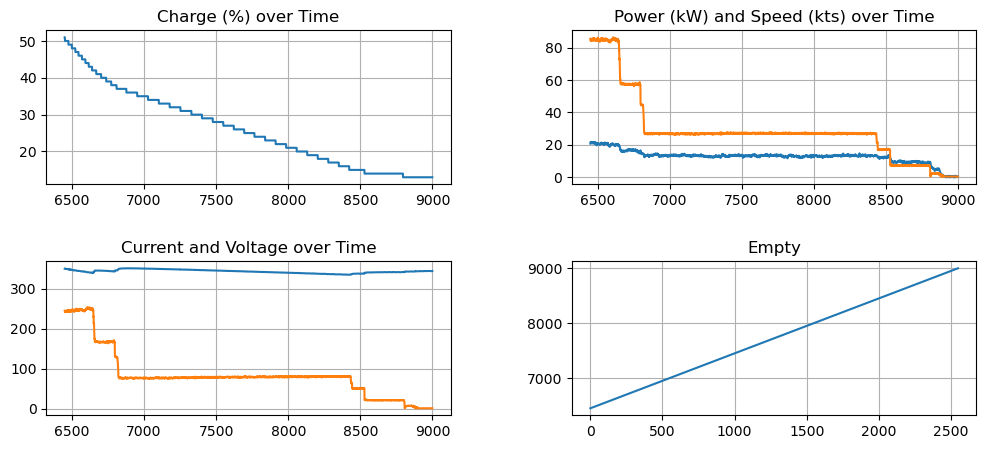

In [62]:
"""Format and clean test data:"""
run = 26
# Extracting columns simplifies the database for visual purposes.
# It will eventually be extraneous.
columns = ['Date', 'Time', 'Lat', 'Lon', 'Speed m/s', 'Distance km',
        'RPM 1', 'Motor Load 1 %', 'Motor Torque 1 %', 'Motor Temp 1 C',
        'Pack Current 1 A', 'Pack Voltage 1 V', 'Pack Temp 1 C', 'SOC 1 %',
        'Power 1 kW', 'Speed kts', 'Distance nm'
        ## 'Battery Health', 'Water Speed'
        ]
df = data['Run %i' % run][columns]
df = df[500:]
print(data_files.file_summary.iloc[run-1])

'''Interesting Plots'''
plt.figure(figsize=(12,5))
plt.subplot(2,2,1)
plt.plot(df.index, df['SOC 1 %'])
plt.grid()
plt.title('Charge (%) over Time')

plt.subplot(2,2,2)
plt.plot(df.index, df['Speed kts'], df['Power 1 kW'])
plt.grid()
plt.title('Power (kW) and Speed (kts) over Time')

plt.subplot(2,2,3)
plt.plot(df.index, df['Pack Voltage 1 V'], df['Pack Current 1 A'])
plt.grid()
plt.title('Current and Voltage over Time')

plt.subplot(2,2,4)
plt.plot(df.index)
plt.grid()
plt.title('Empty')

plt.subplots_adjust(hspace = 0.5)
plt.subplots_adjust(wspace = 0.3)

### Define Algorithms

In [63]:
def overall_avg(initial_data, current_data, batt_cap):
    """This function is based on an overall average of all the data in the trip.
    Takes in a dataframe from the vessel and the capacity of the battery."""

    # dist_list = []

    # for i in range(len(data)):
    #     batt = data['SOC 1 %%'].iloc[i]*batt_cap/100
    #     avg_batt_consumed = (data['SOC 1 %'].iloc[0] - data['SOC 1 %'].iloc[i])*batt_cap/100          #kWh
    #     avg_dist_traveled = (data['Distance nm'].iloc[i] - data['Distance nm'].iloc[0])               #nm

    batt = current_data['SOC 1 %']*batt_cap/100
    avg_batt_consumed = (initial_data['SOC 1 %'] - current_data['SOC 1 %'])*batt_cap/100
    avg_dist_traveled = current_data['Distance nm'] - initial_data['Distance nm']

    avg_consumption = avg_batt_consumed/avg_dist_traveled

    dist_remaining = batt/avg_consumption

        # dist_list.append(dist_remaining)

    return dist_remaining



def rolling_avg(data, batt_cap, N):
    """This function is based on a rolling average consumption rate of N data points.
    Any consumption rates that are not valid, or within the first N data points of the run,
    will default to using the stored average consumption rate."""

    dist_list = []

    cached_avg = data_files.file_summary.iloc[run-1]['Average Consumption (kWh/nm)']       # need a cached average value to default to 
    for i in range(len(data)):
        batt = data['SOC 1 %'].iloc[i]*batt_cap/100
        roll_batt_consumed = (data['SOC 1 %'].iloc[i-N] - data['SOC 1 %'].iloc[i])*batt_cap/100          #kWh
        roll_dist_traveled = (data['Distance nm'].iloc[i] - data['Distance nm'].iloc[i-N])                  #nm
        roll_consumption = roll_batt_consumed/roll_dist_traveled                                            #kWh/nm
        
        if i < N or roll_consumption==0:
            dist_remaining = batt/cached_avg      # This will need to change because we won't know the average with real-time data
            print('%d Batt: %.1f | Consumption Rate: %.2f kWh/nm | Dist Remaining %.1f nm' % (i, batt, cached_avg, dist_remaining), end=' \r')
            # time.sleep(0.001)
        else:
            dist_remaining = batt/roll_consumption   #nm
            print('%d Batt: %.1f | Consumption Rate: %.2f kWh/nm | Dist Remaining: %.2f nm' % (i, batt, roll_consumption, dist_remaining), end=' \r')
            # time.sleep(.001)

        dist_list.append(dist_remaining)

    return dist_list



def update_average():
    """This is a function to update the stored average consumption of the vessel."""

    pass


### Overall Avg Testing Loop

/tmp/ipykernel_1259/3623973790.py:16: RuntimeWarning: invalid value encountered in double_scalars
  avg_consumption = avg_batt_consumed/avg_dist_traveled
/tmp/ipykernel_1259/3623973790.py:18: RuntimeWarning: divide by zero encountered in double_scalars
  dist_remaining = batt/avg_consumption


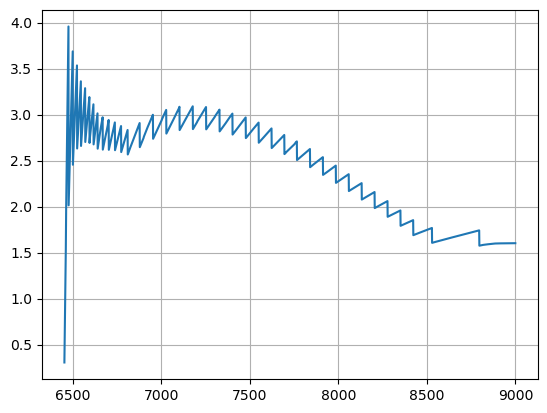

In [64]:
"""
Testing Loop:
    -Loop through CSV rows and update estimated mileage on each iteration
    -Call functions within test loop
    -Nest loops if there are multiple runs or multiple parameters to compare
    -Plot interesting data (R to L):
        --Distance Remaining over time
    -Different runs / parameters (Top Down)
"""
dist_list = []
for i in range(len(df)):
    current_data = df.iloc[i]
    initial_data = df.iloc[0]
    
    dist_remaining = overall_avg(initial_data, current_data, 63)
    print('%d Batt: %.1f | Dist Remaining: %.2f nm' % (i, current_data['SOC 1 %'], dist_remaining), end=' \r')
    # time.sleep(.001)

    dist_list.append(dist_remaining)

plt.plot(df.index, dist_list)
plt.grid()

df['Dist Prediction (nm)'] = dist_list

In [65]:
"""Accuracy Comparison"""
'''Look at how far the vessel traveled 30s later'''

df['Interval Dist'] = ''
df['Interval Pred'] = ''
df['error'] = ''

interval = 30 #seconds
# for i in range(interval, len(df)):
#     interval_dist = df['Distance nm'].iloc[i] - df['Distance nm'].iloc[i-interval]
#     # interval_pred = df['Dist Prediction (nm)'].iloc[i-interval] - df['Dist Prediction (nm)'][i]
#     df['Interval Dist'].iloc[i] = interval_dist
#     # df['Interval Pred'].iloc[i] = interval_pred

dist_500 = df['Distance nm'].iloc[-1] - df['Distance nm'].iloc[500] # Distance traveled from i=500 on
pred_500 = df['Dist Prediction (nm)'].iloc[500] - df['Dist Prediction (nm)'].iloc[-1] 
print(pred_500, dist_500)

1.387398311083053 3.437159998425999


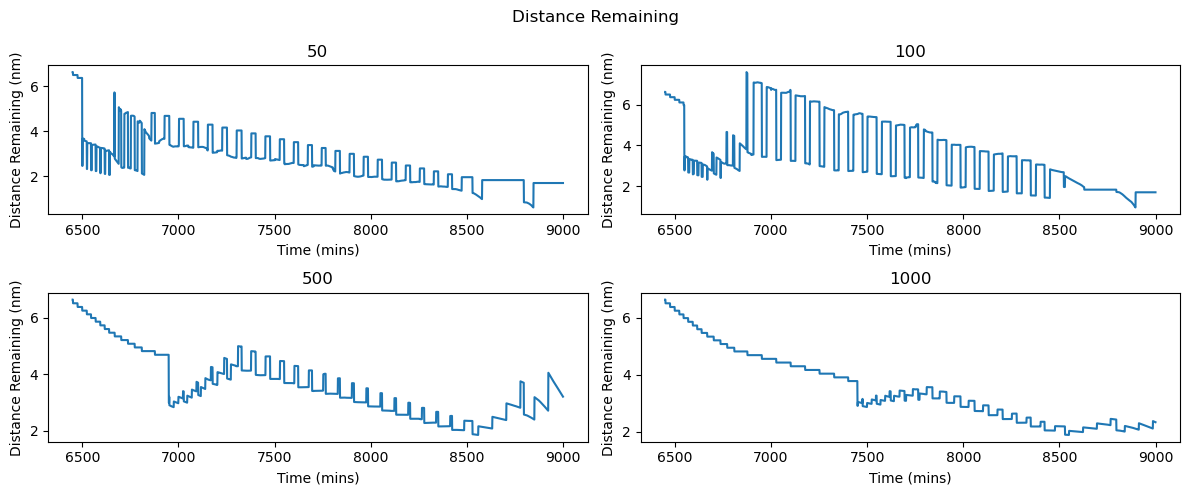

In [66]:
"""Rolling avg plots"""

plt.figure(figsize = (12,5))
plt.suptitle('Distance Remaining')

Nlist = [50, 100, 500, 1000]
rolling_distances = []
# cached_avg = avg_consumption_rate    # This will need to be a locally stored value based on historical data. We want this to be conservative.
for N in Nlist:

    dist_list = rolling_avg(df, 63, N)
    rolling_distances.append(dist_list)

    n = Nlist.index(N)
    plt.subplot(2,2,n+1)
    plt.title(N)
    plt.plot(df.index, rolling_distances[n])
    plt.xlabel("Time (mins)")
    plt.ylabel('Distance Remaining (nm)')

    plt.subplots_adjust(hspace = 0.5)
    plt.subplots_adjust(wspace = 0.3)

plt.tight_layout()


In [67]:
"""Test Loop for Plot: An attempt to plot time versus distance remaining, 
   calculated every 10 seconds in order to smooth final curve.
   Currently not yet working, running into error of 'Output exceeds the 
   size limit. Open the full output data in a text editor'. I am inclined 
   to believe that matplotlib has trouble processing datetime format of the 
   'Time' column. 
"""
sample_list = [1,10,20,30,40,50,60]
distances = []
time0 = [] 
for N in sample_list:
    distanceList = [] 
    time1 = []
    count = 0
    for i in range(len(df)):
        batt = df['SOC 1 %%'].iloc[i]*batt_cap/100        # Change into kWh based on 63 kWh full charge
        dist = batt/avg_consumption_rate            # In km. Will eventually need to be nm
        print('Battery Remaining = %.1f kWh | Distance Remaining = %.1f nm' % (batt, dist), end=' \r')
        # time.sleep(.001)
        count += 1
        if count % N == 0:
            time2 = df['Time'].iloc[i]    #fixed it here, "Only append the current time value"
            time1.append(time2)
            distanceList.append(dist)

    distances.append(distanceList)
    time0.append(time1)

plt.figure(figsize = (17,34))
plt.suptitle('Distance Remaining in Nautical Miles Over the Course of Trip', y=1) 

index = 1
for i in range (0,7):
    plt.subplot(7,2,index)
    index +=1
    plt.title(f'int = {sample_list[i]}')
    plt.plot(time0[i], distances[i])
    space = np.array(range(0,int(np.max(time0[i])),200))
    plt.xticks(space,labels = np.round(space/60,0))
    plt.xlabel("Time (mins)")
    plt.ylabel('Distance Remaining (nm)')

    plt.subplots_adjust(hspace = 0.5)

    #Smooth line version of graph 
    plt.subplot(7,2,index)
    index+=1 
    x_smooth = np.linspace(np.min(time0[i]),np.max(time0[i]),num = 25) #Num represents number of points, play around to affect smoothness
    bspline = interpolate.make_interp_spline(time0[i], distances[i])
    y_smooth = bspline(x_smooth)
    plt.title(f'Smoothing: int = {sample_list[i]}')
    plt.plot(x_smooth,y_smooth)
    plt.xticks(space,labels = np.round(space/60,0))
    plt.xlabel("Time (mins)")
    plt.ylabel('Distance Remaining (nm)')
    plt.subplots_adjust(wspace = 0.3)

plt.tight_layout()

KeyError: 'SOC 1 %%'